 # 单因子分析：新隔夜因子 (MIF, Market Inefficiency Factor)

**目标**: 本 Notebook 旨在根据国盛证券《如何将隔夜涨跌变为有效的选股因子?》的研究报告，构建并回测报告中提出的新隔夜因子 (MIF)。

**核心思想**: 
1.  **数据准备**: 加载干净的股票行情数据，并计算构建因子所需的中间变量，如隔夜收益率、昨日换手率等。
2.  **因子计算**: 遵循研报的步骤构建MIF因子：
    a. 计算每个月底，过去20日内 **“隔夜涨跌幅绝对值”** 与 **“昨日换手率”** 的相关系数。
    b. 对上述相关系数因子进行 **市值中性化** 处理。
    c. 计算市值中性化后的 **“隔夜跳空因子”** (`abs_OvernightRet_desize`)。
    d. 将步骤b的结果对步骤c的结果进行 **正交化**（回归取残差），得到最终的MIF因子。
3.  **分组回测**: 根据研报结论（因子IC为负），我们将做多因子值最低的组（Group 1），做空因子值最高的组（Group 5）。
4.  **业绩分析**: 通过多空组合的净值曲线、年化收益、IC分析等指标来评估该因子的有效性。

In [12]:
# -- 步骤 0: 导入必要的库并设置项目路径 --
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 设置matplotlib以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# 将项目根目录添加到Python的模块搜索路径中
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
# 从项目中导入我们需要的模块
from data_manager.loader import load_and_clean_data
from backtest_engine.engine import BacktestEngine
from backtest_engine.performance import PerformanceAnalyzer

print(f"项目根目录已设置为: {project_root}")

项目根目录已设置为: /Users/nachuanchen/Documents/Undergrad_Resources/投资学/Factor_strategy_platform


### 步骤 1: 加载并清洗数据
我们首先调用 `data_manager` 模块中的 `load_and_clean_data` 函数来获取 `master_data` 数据框。

In [13]:
DATA_DIR_PATH = os.path.join(project_root, "data_manager", "DemoData")

master_df, index_df = load_and_clean_data(DATA_DIR_PATH)

if master_df is not None:
    print("\n主数据加载成功，预览:")
    display(master_df.head())

开始执行数据加载与清洗任务...

[步骤 1/4] 正在加载CSV文件...
所有CSV文件加载成功！

[步骤 2/4] 正在进行数据预处理...
 -> 行情数据处理完成，已计算后复权价。
 -> 财务数据处理完成。
 -> 指数数据处理完成。

[步骤 3/4] 正在合并行情与财务数据...
行情与财务数据合并成功！

[步骤 4/4] 正在进行最终清洗...
 -> 已对财务数据进行缩尾处理。

数据加载与清洗任务完成！

主数据加载成功，预览:


open   high    low  close   adjfactor       volume  \
date       stock_code                                                        
2024-01-02 000001.SZ    9.39   9.42   9.21   9.21   71.643514  115836645.0   
           000002.SZ   10.44  10.48  10.15  10.15  181.703787   81110629.0   
           000004.SZ   16.10  16.44  16.05  16.14    4.063862    2886700.0   
           000005.SZ    1.08   1.12   1.08   1.12    9.267603    6302800.0   
           000006.SZ    4.58   4.60   4.45   4.47   39.739675   26194719.0   

                                amt   mkt_cap_ard      turn    adj_close  \
date       stock_code                                                      
2024-01-02 000001.SZ   1.075742e+09  1.787285e+11  0.596925   659.836764   
           000002.SZ   8.307655e+08  1.210967e+11  0.834735  1844.293438   
           000004.SZ   4.679115e+07  2.136618e+09  2.285805    65.590733   
           000005.SZ   6.967071e+06  1.185561e+09  0.595758    10.379715   
           000006.SZ   1.176632e+08  6.034478e+09  1.940368   177.636347   

                          adj_open report_date  ROE_AVG     ROA2  CATOASSETS  \
date       stock_code                                                          
2024-01-02 000001.SZ    672.732596  2023-12-31  10.2436      NaN         NaN   
           000002.SZ   1896.987536  2023-12-31   4.9294   1.9955     76.4368   
           000004.SZ     65.428178  2023-12-31 -57.2888 -35.8637     78.4352   
           000005.SZ     10.009011  2023-12-31 -17.9094  -8.1847     56.6478   
           000006.SZ    182.007711  2023-12-31 -10.7927  -1.3205     84.0593   

                       ASSETSTOEQUITY  CURRENT  
date       stock_code                           
2024-01-02 000001.SZ          11.8289      NaN  
           000002.SZ           3.7347   1.3997  
           000004.SZ           2.1326   1.6630  
           000005.SZ           2.1801   1.6617  
           000006.SZ           3.4829   1.7350

### 步骤 2: 构建新隔夜因子 (MIF)
为了方便复用和管理，我们将研报中描述的因子计算逻辑封装在一个类 `OvernightFactor` 中。这个类将处理所有复杂的计算步骤。

In [27]:
class OvernightFactor:
    """
    计算新隔夜因子 (MIF) 类。
    该因子的核心逻辑基于国盛证券的研究报告，旨在刻画知情交易者的信息优势。
    """

    def __init__(self, master_data, lookback_period=20):
        required_cols = ['adj_open', 'adj_close', 'turn', 'mkt_cap_ard']
        if not all(col in master_data.columns for col in required_cols):
            raise ValueError(f"错误: 输入的数据中缺少必要的字段。需要: {required_cols}")
        self.master_data = master_data.copy()
        self.lookback_period = lookback_period
        self.factor_name = 'MIF'

    def _calculate_intermediate_factors(self):
        print("\n[因子计算] 正在准备中间数据...")
        self.master_data['overnight_ret'] = self.master_data.groupby(level='stock_code')['adj_open'].transform(lambda x: x / x.shift(1)) - 1
        self.master_data['abs_overnight_ret'] = self.master_data['overnight_ret'].abs()
        self.master_data['yesterday_turn'] = self.master_data.groupby(level='stock_code')['turn'].shift(1)
        self.master_data['log_market_cap'] = np.log(self.master_data['mkt_cap_ard'])
        self.master_data['abs_overnight_ret_mean'] = self.master_data.groupby(level='stock_code')['abs_overnight_ret'].transform(
            lambda x: x.rolling(window=self.lookback_period).mean()
        )
        print(" -> 中间数据计算完成。")

    def _neutralize(self, group, factor_col, by_col='log_market_cap'):
        # 移除该分组中任何包含NaN的行
        clean_group = group[[factor_col, by_col]].dropna()
        if clean_group.shape[0] < 2:
            return pd.Series(np.nan, index=group.index)
        
        Y = clean_group[factor_col]
        X = sm.add_constant(clean_group[by_col])
        model = sm.OLS(Y, X).fit()
        
        # 将残差放回原始索引
        residuals = pd.Series(model.resid, index=clean_group.index)
        return residuals.reindex(group.index)

    def calculate_factor(self):
        self._calculate_intermediate_factors()
        
        data = self.master_data.copy()
        
        print(f"\n[因子计算] 步骤 1/4: 计算 {self.lookback_period}日相关系数...")
        data['corr_factor'] = data.groupby('stock_code', group_keys=False).apply(
            lambda x: x['abs_overnight_ret'].rolling(self.lookback_period).corr(x['yesterday_turn'])
        )
        print(" -> 相关系数计算完成。")
        
        # 筛选出所有基础因子都有值的行
        valid_base = data.dropna(subset=['corr_factor', 'log_market_cap', 'abs_overnight_ret_mean']).copy()
        if valid_base.empty:
            print("\n[因子计算] 警告: 没有足够的数据来计算因子。")
            return pd.DataFrame(columns=[self.factor_name])

        print("\n[因子计算] 步骤 2 & 3: 进行市值中性化...")
        valid_base['corr_factor_neutralized'] = valid_base.groupby('date', group_keys=False).apply(self._neutralize, 'corr_factor')
        valid_base['abs_overnight_ret_desize'] = valid_base.groupby('date', group_keys=False).apply(self._neutralize, 'abs_overnight_ret_mean')
        print(" -> 市值中性化完成。")

        # 筛选出两次中性化之后依然有有效值的行
        final_data_for_ortho = valid_base.dropna(subset=['corr_factor_neutralized', 'abs_overnight_ret_desize']).copy()
        if final_data_for_ortho.empty:
            print("\n[因子计算] 警告: 中性化后没有足够的数据进行正交化。")
            return pd.DataFrame(columns=[self.factor_name])

        print("\n[因子计算] 步骤 4/4: 对隔夜跳空因子进行正交化，生成 MIF...")
        
        def orthogonalize(group):
            Y = group['corr_factor_neutralized']
            X = sm.add_constant(group['abs_overnight_ret_desize'])
            model = sm.OLS(Y, X).fit()
            return pd.Series(model.resid, index=group.index)

        residuals = final_data_for_ortho.groupby('date', group_keys=False).apply(orthogonalize)
        mif_factor_df = pd.DataFrame({self.factor_name: residuals})
        
        print(f"\n[因子计算] {self.factor_name} (新隔夜因子) 计算完成！")
        
        return mif_factor_df

# 使用完整数据计算因子
if master_df is not None:
    print("使用全部数据（1月至6月）计算因子，以保证有足够的回看期...")
    overnight_calculator = OvernightFactor(master_df, lookback_period=20)
    mif_factor_df_full = overnight_calculator.calculate_factor()

    # 筛选出2月1日及之后的因子值用于回测
    if not mif_factor_df_full.empty:
        # **重要**: 在回测前，将因子数据框的索引设置为['date', 'stock_code']
        if not isinstance(mif_factor_df_full.index, pd.MultiIndex):
             mif_factor_df_full = mif_factor_df_full.set_index(['date', 'stock_code'])
        
        mif_factor_df = mif_factor_df_full.loc[mif_factor_df_full.index.get_level_values('date') >= '2024-02-01']
        print(f"\\n因子值已筛选，回测将从 {mif_factor_df.index.get_level_values('date').min().date()} 开始。")
    else:
        mif_factor_df = mif_factor_df_full

    print("\n新隔夜因子 (MIF) 计算完成，预览回测用的数据:")
    display(mif_factor_df.dropna().head())

使用全部数据（1月至6月）计算因子，以保证有足够的回看期...

[因子计算] 正在准备中间数据...
 -> 中间数据计算完成。

[因子计算] 步骤 1/4: 计算 20日相关系数...
 -> 相关系数计算完成。

[因子计算] 步骤 2 & 3: 进行市值中性化...
 -> 市值中性化完成。

[因子计算] 步骤 4/4: 对隔夜跳空因子进行正交化，生成 MIF...

[因子计算] MIF (新隔夜因子) 计算完成！
\n因子值已筛选，回测将从 2024-02-01 开始。

新隔夜因子 (MIF) 计算完成，预览回测用的数据:


MIF
date       stock_code          
2024-02-01 000001.SZ   0.159141
           000002.SZ   0.396832
           000004.SZ  -0.410380
           000005.SZ   0.171643
           000006.SZ   0.383828

### 步骤 3: 运行分组回测
我们将计算出的 `mif_factor_df` 传入 `BacktestEngine`。

关键假设：
- **`long_direction = 'low'`**: 根据研报结论，MIF因子是一个反转类因子，其IC值为负。这意味着因子值越大的股票，未来预期收益越低；因子值越小的股票，未来预期收益越高。因此，我们的多空策略应该是 **做多因子值最低的组 (Group 1)，做空因子值最高的组 (Group 5)**。

In [28]:
# **修正部分**: 在运行回测前，检查因子DataFrame是否为空
if 'mif_factor_df' in locals() and not mif_factor_df.dropna().empty:
    backtest = BacktestEngine(
        master_data=master_df, 
        factor_data=mif_factor_df, 
        n_groups=5, 
        long_direction='low' # 关键：根据研报结论，做多因子值最低的组合
    )

    portfolio_returns = backtest.run()

    print("\n回测完成，各投资组合每日收益率预览：")
    display(portfolio_returns.head())
else:
    # 如果因子计算结果为空，则跳过回测
    portfolio_returns = None
    print("\n跳过回测：因为样本数据时间跨度小于回看期，未能计算出有效的因子值。")


Backtest Engine initialized. Long direction set to: 'low'

[Backtest] Starting vectorized backtest...
 -> Step 1: Data alignment and merge complete.
 -> Step 2: Stocks grouped into 5 portfolios based on 'MIF'.
 -> Step 3: Daily group returns calculated.
 -> Strategy: Long Group_1, Short Group_5
 -> Step 4: Long-Short portfolio constructed correctly.
[Backtest] Backtest execution finished!

回测完成，各投资组合每日收益率预览：


,Group_1,Group_2,Group_3,Group_4,Group_5,Long_Short,Long_Only
date,,,,,,,
2024-02-01,-0.036462,-0.030632,-0.037763,-0.023716,-0.035545,-0.000918,-0.036462
2024-02-02,-0.055225,-0.064109,-0.065827,-0.066684,-0.074483,0.019258,-0.055225
2024-02-05,0.003945,0.023122,0.026742,0.028155,0.011143,-0.007198,0.003945
2024-02-06,-0.027910,0.008015,-0.000296,-0.002596,0.002777,-0.030687,-0.027910
2024-02-07,0.029567,0.039350,0.039823,0.050871,0.049647,-0.020080,0.029567


### 步骤 4: 性能分析与可视化
最后，我们使用 `PerformanceAnalyzer` 对回测结果进行全面的分析，评估新隔夜因子的有效性。

Performance Analyzer initialized.

[Performance Analysis] Calculating portfolio performance metrics...
Portfolio Performance Metrics:
            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Group_1               -0.2130                 0.2791       -0.7632   
Group_2               -0.0121                 0.2891       -0.0418   
Group_3               -0.1077                 0.2947       -0.3655   
Group_4               -0.0795                 0.2842       -0.2799   
Group_5               -0.1864                 0.2960       -0.6298   
Long_Short            -0.0441                 0.1184       -0.3725   
Long_Only             -0.2130                 0.2791       -0.7632   

            Max Drawdown  Information Ratio (vs Benchmark)  
Group_1          -0.1724                               NaN  
Group_2          -0.1706                               NaN  
Group_3          -0.1817                               NaN  
Group_4          -0.1613                               NaN  


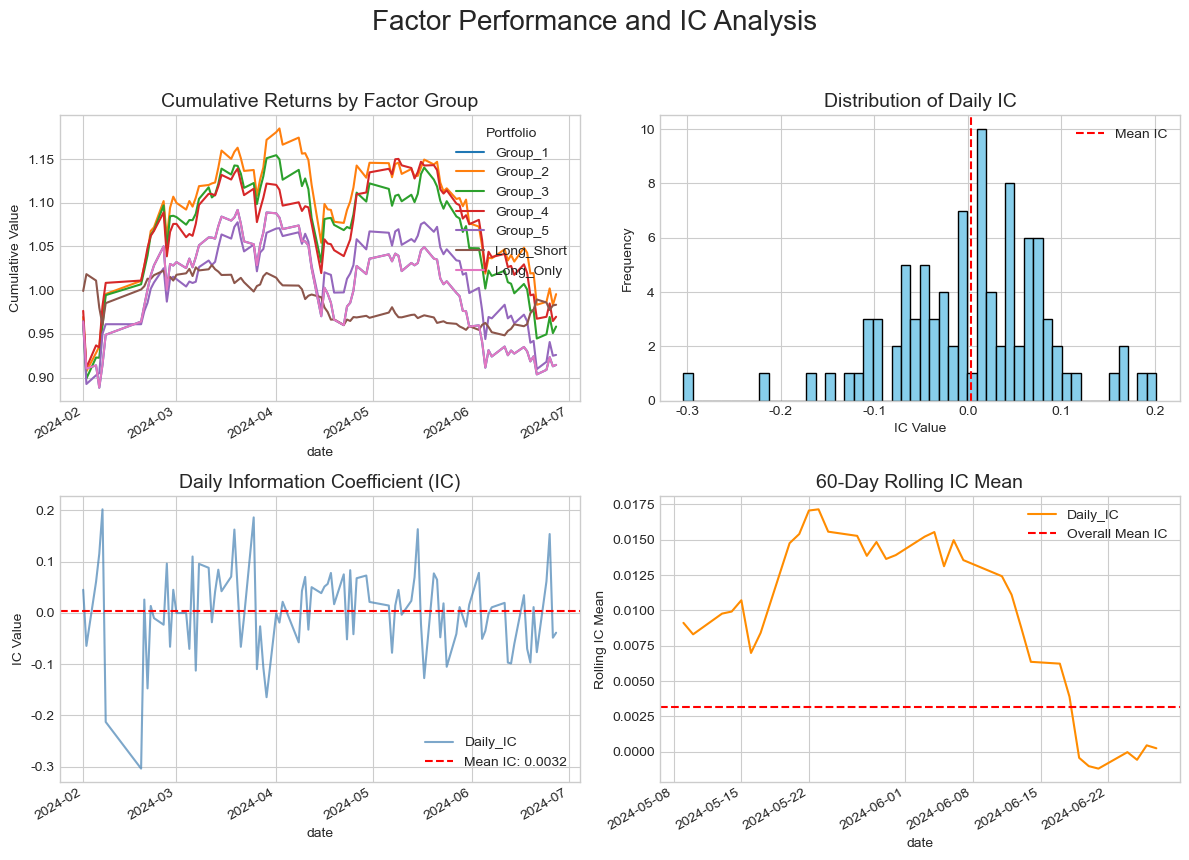

Plotting complete.


In [29]:
# **修正部分**: 在进行性能分析前，检查回测结果是否存在
if 'portfolio_returns' in locals() and portfolio_returns is not None:
    analyzer = PerformanceAnalyzer(portfolio_returns, mif_factor_df, master_df)
    
    # 1. 计算各项性能指标
    analyzer.calculate_metrics()
    
    # 2. 绘制图表
    analyzer.plot_results()
else:
    print("\n跳过性能分析：因为回测步骤未能执行。")

### 结论解读

根据上方的图表和指标，我们可以对MIF因子在回测期间（您的数据样本内）的表现做出初步判断：

- **净值曲线 (`Cumulative Returns`)**: 如果 `Long_Short`（多空对冲）组合的净值曲线长期、稳定地向上，说明该因子具备有效的选股能力。这验证了做多因子值低的股票、做空因子值高的股票的策略是有效的。
- **分组收益 (`Group Cumulative Returns`)**: 我们期望看到从Group 1到Group 5的最终净值呈现 **单调递减** 的趋势。即Group 1 (因子值最小) 收益最高，Group 5 (因子值最大) 收益最低。这会直观地证明因子的有效性。
- **IC分析 (`Information Coefficient Analysis`)**: 我们期望IC均值显著 **小于0**，并且ICIR（信息比率）的绝对值较大（研报中达到了-2.43），这说明因子具有很强的负向预测能力。

多空组合（Long-Short）收益为负
根据研报的结论，您的策略是正确的：做多因子值最低的股票（第1组），同时做空因子值最高的股票（第5组）。

您的结果：Long-Short（多空）组合的年化收益率为 -4.41%，夏普比率为 -0.3725。

研报结果：在其2012-2022年的测试期内，该策略的年化收益率高达 +10.91%，信息比率（与夏普比率类似）为 2.49。

结论：这是最直接的证据，表明该因子在您的回测期间其预测能力发生了反转。因子认为的“好”股票（MIF值低）实际上表现得比因子认为的“坏”股票（MIF值高）更差。

2. 信息系数（IC）为正，而非负
IC（Information Coefficient）衡量的是因子值与股票未来收益率之间的相关性。研报的核心论点是MIF因子应该具有一个负的IC值。

您的结果：IC均值为 +0.0032，这个值不仅非常接近于零，而且是正数。ICIR（衡量IC值稳定性的指标）也仅为 0.0383，几乎可以忽略不计。

研报结果：研报发现了一个显著为负的IC均值 -0.028，以及非常稳定的ICIR -2.43。

结论：您的IC分析结果证实，在2024年的样本数据中，该因子没有表现出稳定的负向预测能力。一个正的IC值，即便很小，也直接违背了这个因子的构建初衷。

3. 分组收益没有呈现单调性
对于一个有效的负向因子，我们期望看到各组的收益率从第1组到第5组呈现单调递减的趋势。

您的结果：各组收益率并没有清晰的规律。事实上，被选为“多头”的第1组，其表现最差，年化收益率为 -21.30%。

研报结果：研报中的分组回测图清晰地显示，收益率从因子值最低的组到最高的组呈现单调递减的趋势，其中第一组（多头）收益最高，第五组（空头）收益最低。

结论：您的分组收益缺乏明显的递减趋势，进一步证明了该因子在您的测试窗口内是无效的。